Epoch [  1] | Val: 542.8930 | Neg: 70.3181 | LR: 0.000500
Epoch [ 10] | Val: 99.5426 | Neg: 5.8036 | LR: 0.000500
Epoch [ 20] | Val: 46.9201 | Neg: 2.4453 | LR: 0.000500
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
Epoch [ 30] | Val: 30.6919 | Neg: 1.4251 | LR: 0.000500
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 4 out of 40
Epoch [ 40] | Val: 20.9628 | Neg: 0.9901 | LR: 0.000500
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 40
EarlyStopping counter: 2 out of 40
Epoch [ 50] | Val: 17.3822 | Neg: 0.7118 | LR: 0.000500
EarlyStopping counter: 3 out of 40
EarlyStopping counter: 1 out of 

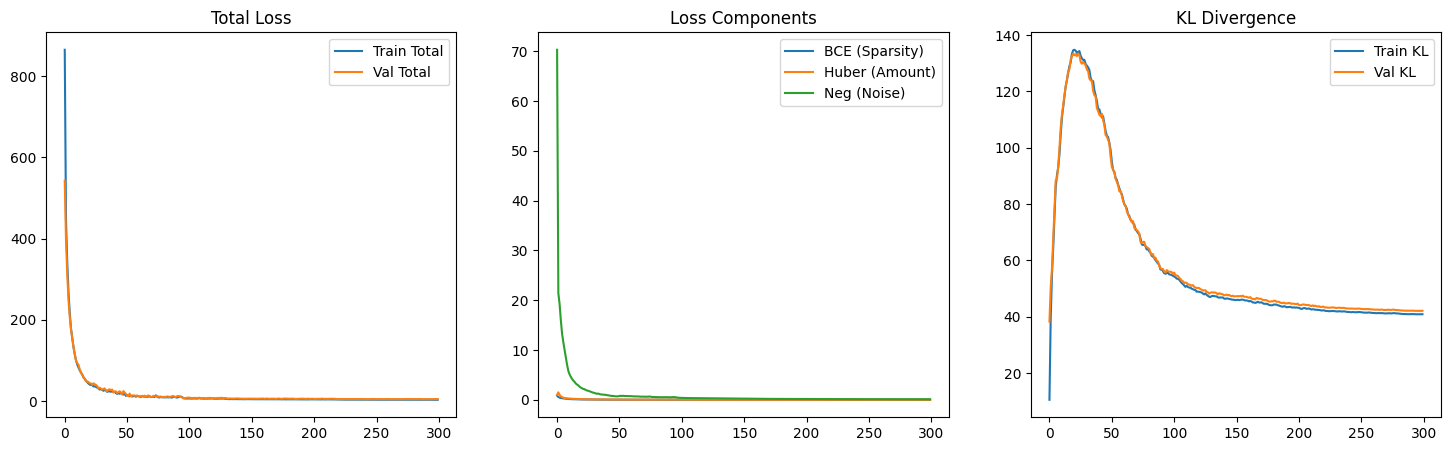

In [1]:
import torch.optim as optim
import matplotlib.pyplot as plt
from vae_earlystopping import EarlyStopping
# 파일 경로에 맞춰 import 확인 (예: from model.new_hurdle_model import ...)
from model.new_hurdle_model import AdvancedHurdleCVAE, advanced_hurdle_loss
import numpy as np
import torch 

# 1. 데이터 로드 및 설정
train_loader = torch.load('torch/train_loader.pt', weights_only=False)
val_loader = torch.load('torch/val_loader.pt', weights_only=False)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

x_sample, c_sample = next(iter(train_loader))
model = AdvancedHurdleCVAE(x_dim=x_sample.shape[1], c_dim=c_sample.shape[1]).to(device)

optimizer = optim.Adam(model.parameters(), lr=5e-4, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=15, factor=0.5)
early_stopping = EarlyStopping(patience=40)

history = {
    'train_total': [], 'val_total': [], 'val_kl': [],
    'train_bce': [], 'train_huber': [], 'train_kl': [], 'train_neg': []
}

epochs = 500
beta_max = 0.05 

# 2. 학습 루프
for epoch in range(1, epochs + 1):
    model.train()
    t_loss, t_bce, t_huber, t_kl, t_neg = 0, 0, 0, 0, 0
    
    # 전략: 초반 50에폭은 Sparsity(위치)를 잡기 위해 alpha(BCE 가중치)를 높게 둡니다.
    current_alpha = 10.0 if epoch < 50 else 5.0 
    beta = min(beta_max, (epoch / (epochs * 0.4)) * beta_max)

    for x, c in train_loader:
        x, c = x.to(device), c.to(device)
        optimizer.zero_grad()
        
        p_logits, mu_log, logvar_log, mu_z, logvar_z = model(x, c)
        
        # [중요] 수정된 advanced_hurdle_loss 매개변수에 맞춰 호출
        # lambda_reg는 150~200 정도가 가장 안정적입니다 (500은 너무 튐)
        loss_dict = advanced_hurdle_loss(
            p_logits, mu_log, logvar_log, x, mu_z, logvar_z, 
            alpha=current_alpha, 
            beta=beta, 
            lambda_reg=150.0, # 수치 복원 가중치
            eps=1e-6
        )
        
        if torch.isnan(loss_dict['loss']):
            continue

        loss_dict['loss'].backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        
        t_loss += loss_dict['loss'].item()
        t_bce += loss_dict['bce'].item()
        t_huber += loss_dict['huber'].item()
        t_kl += loss_dict['kl'].item()
        t_neg += loss_dict['neg'].item()

    # Validation
    model.eval()
    v_loss, v_kl = 0, 0
    with torch.no_grad():
        for x_v, c_v in val_loader:
            x_v, c_v = x_v.to(device), c_v.to(device)
            p_v, m_v, lv_v, muz_v, logz_v = model(x_v, c_v)
            v_loss_dict = advanced_hurdle_loss(
                p_v, m_v, lv_v, x_v, muz_v, logz_v, 
                alpha=current_alpha, beta=beta, lambda_reg=150.0
            )
            v_loss += v_loss_dict['loss'].item()
            v_kl += v_loss_dict['kl'].item()

    # 히스토리 업데이트
    n_t, n_v = len(train_loader), len(val_loader)
    history['train_total'].append(t_loss / n_t)
    history['val_total'].append(v_loss / n_v)
    history['val_kl'].append(v_kl / n_v)
    history['train_bce'].append(t_bce / n_t)
    history['train_huber'].append(t_huber / n_t)
    history['train_kl'].append(t_kl / n_t)
    history['train_neg'].append(t_neg / n_t)

    scheduler.step(v_loss / n_v)
    
    if epoch % 10 == 0 or epoch == 1:
        print(f"Epoch [{epoch:3d}] | Val: {history['val_total'][-1]:.4f} | Neg: {history['train_neg'][-1]:.4f} | LR: {optimizer.param_groups[0]['lr']:.6f}")

    if early_stopping(history['val_total'][-1], model):
        break

early_stopping.load_best_model(model)

# 3. 시각화
plt.figure(figsize=(18, 5))
plt.subplot(1, 3, 1)
plt.plot(history['train_total'], label='Train Total')
plt.plot(history['val_total'], label='Val Total')
plt.title('Total Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(history['train_bce'], label='BCE (Sparsity)')
plt.plot(history['train_huber'], label='Huber (Amount)')
plt.plot(history['train_neg'], label='Neg (Noise)')
plt.title('Loss Components')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(history['train_kl'], label='Train KL')
plt.plot(history['val_kl'], label='Val KL')
plt.title('KL Divergence')
plt.legend()
plt.show()

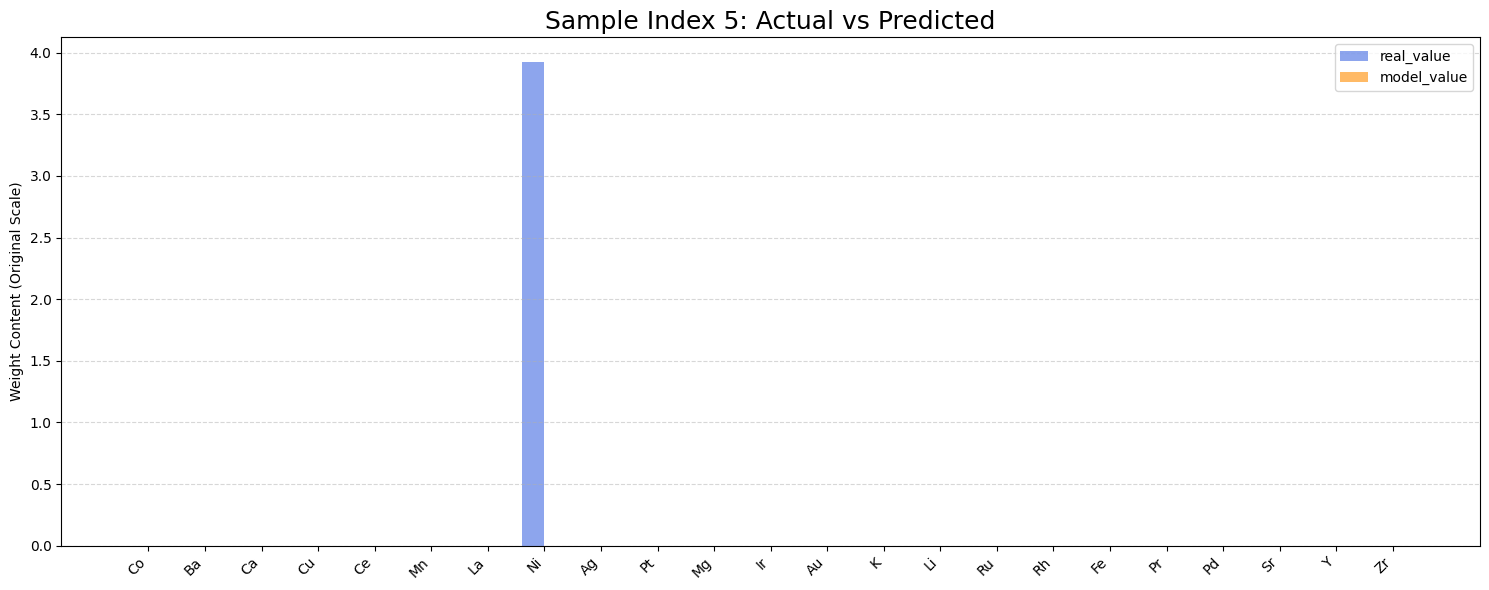

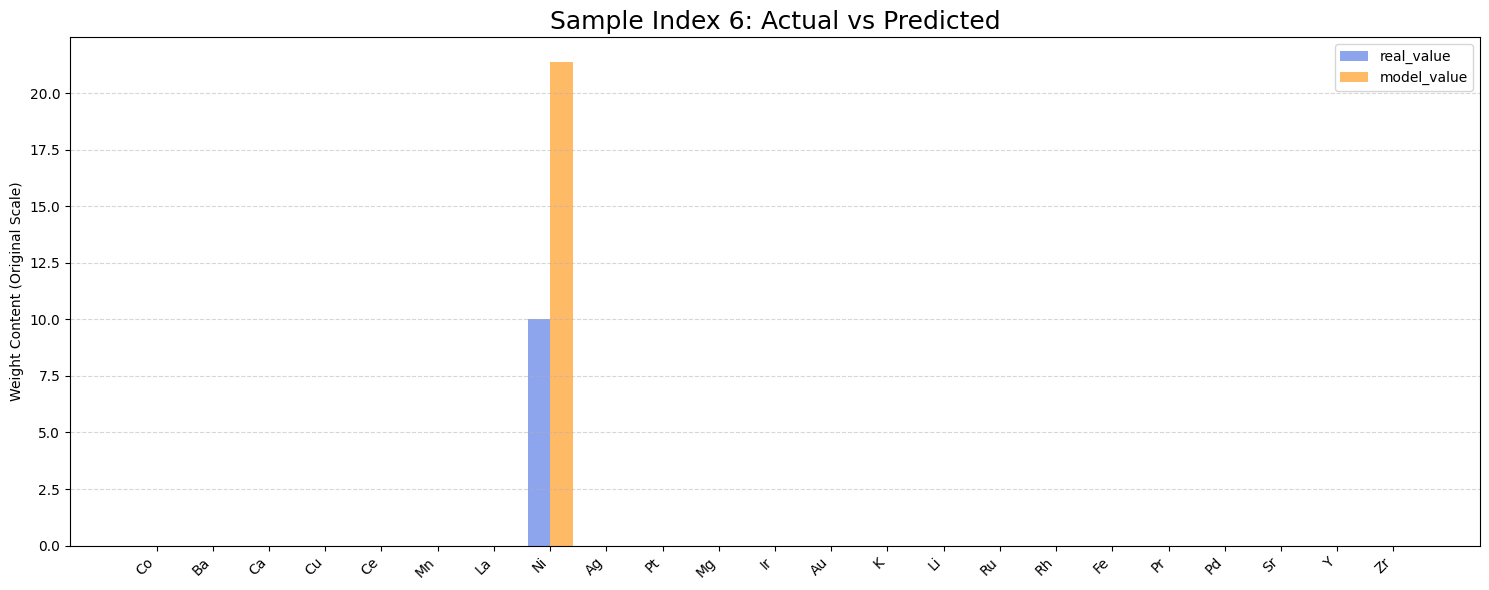

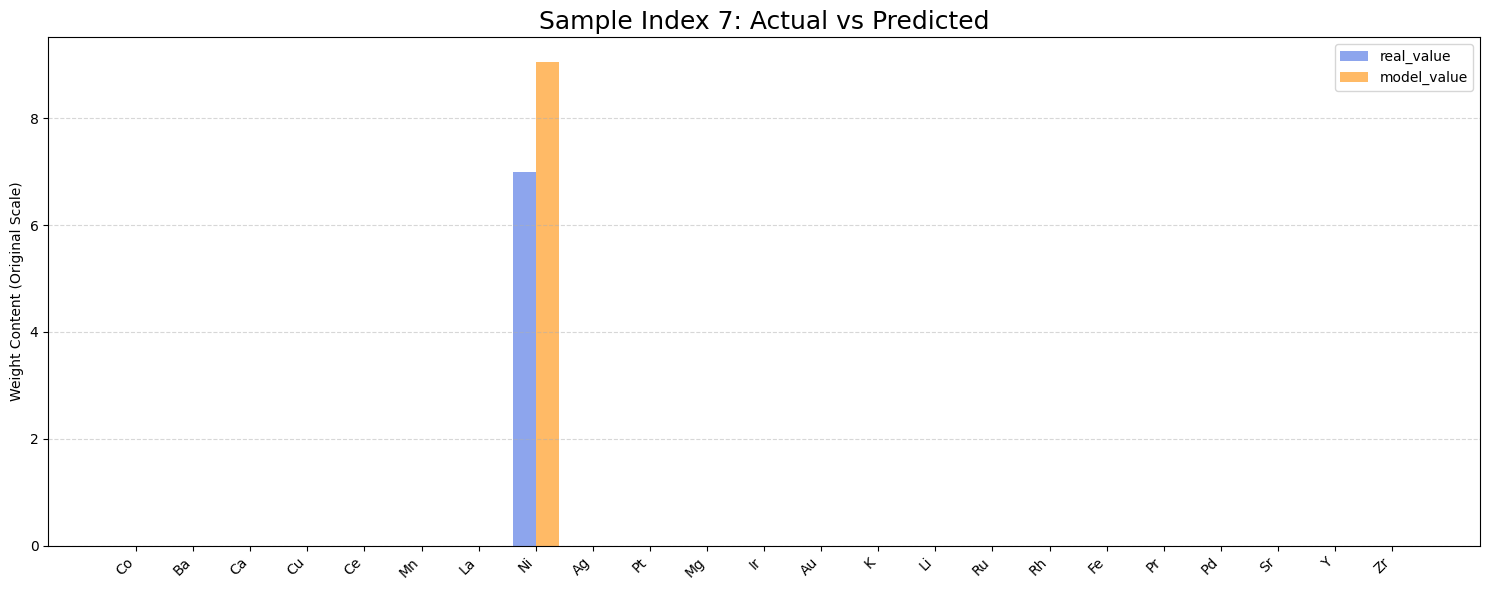

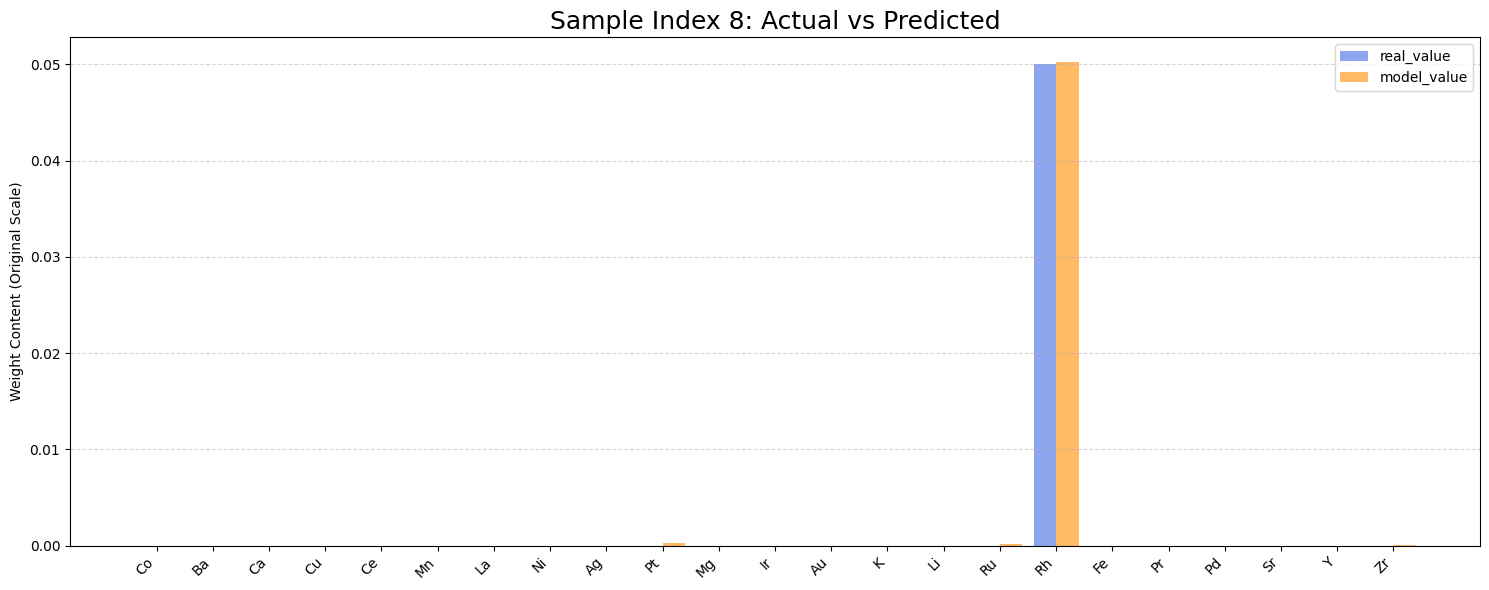

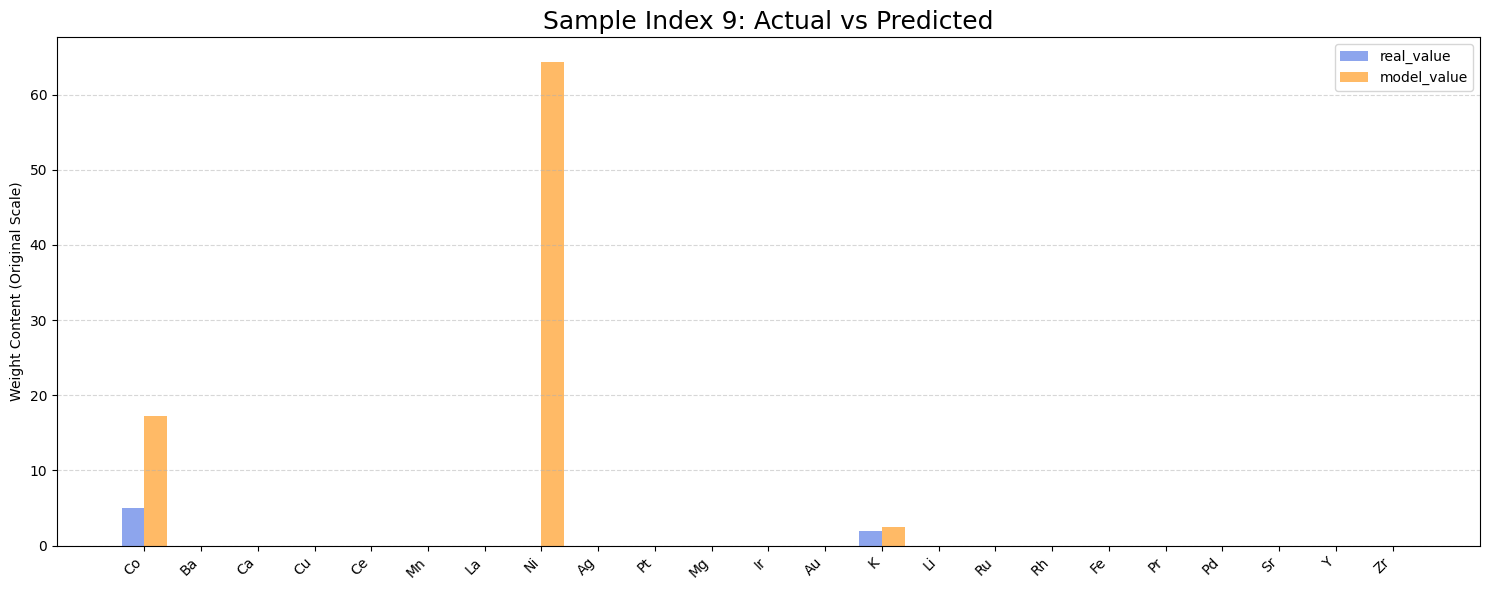

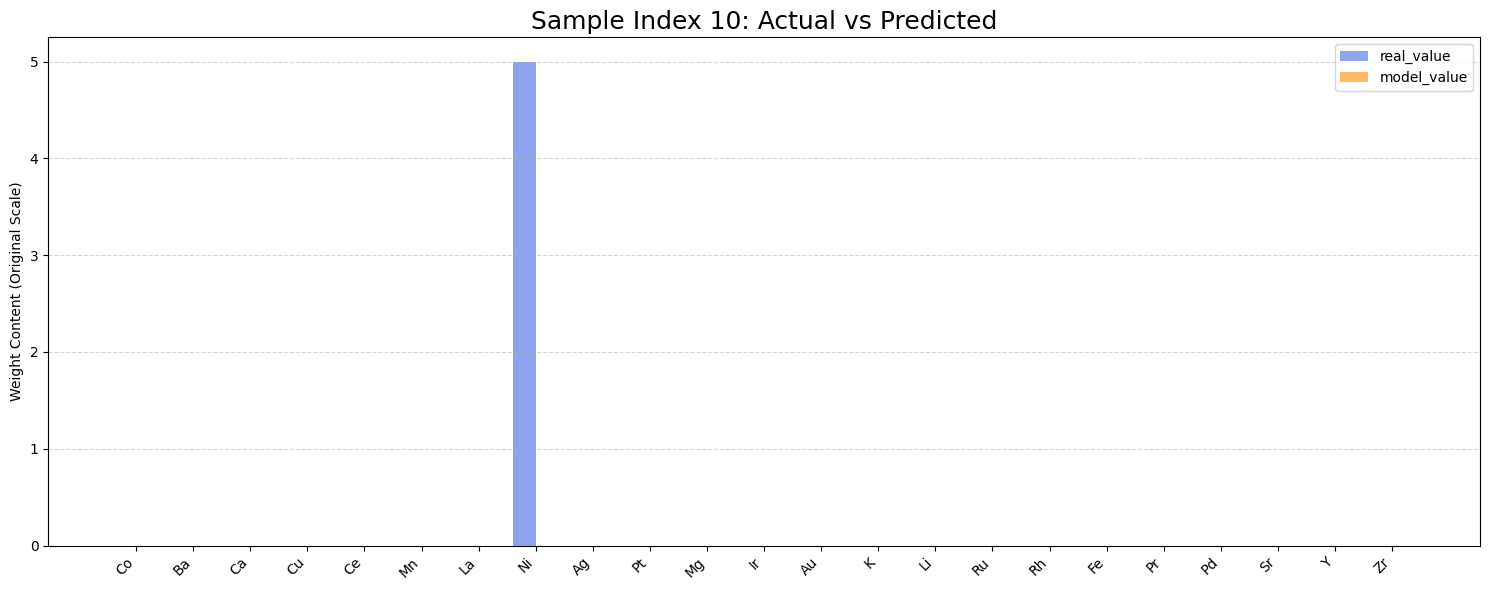

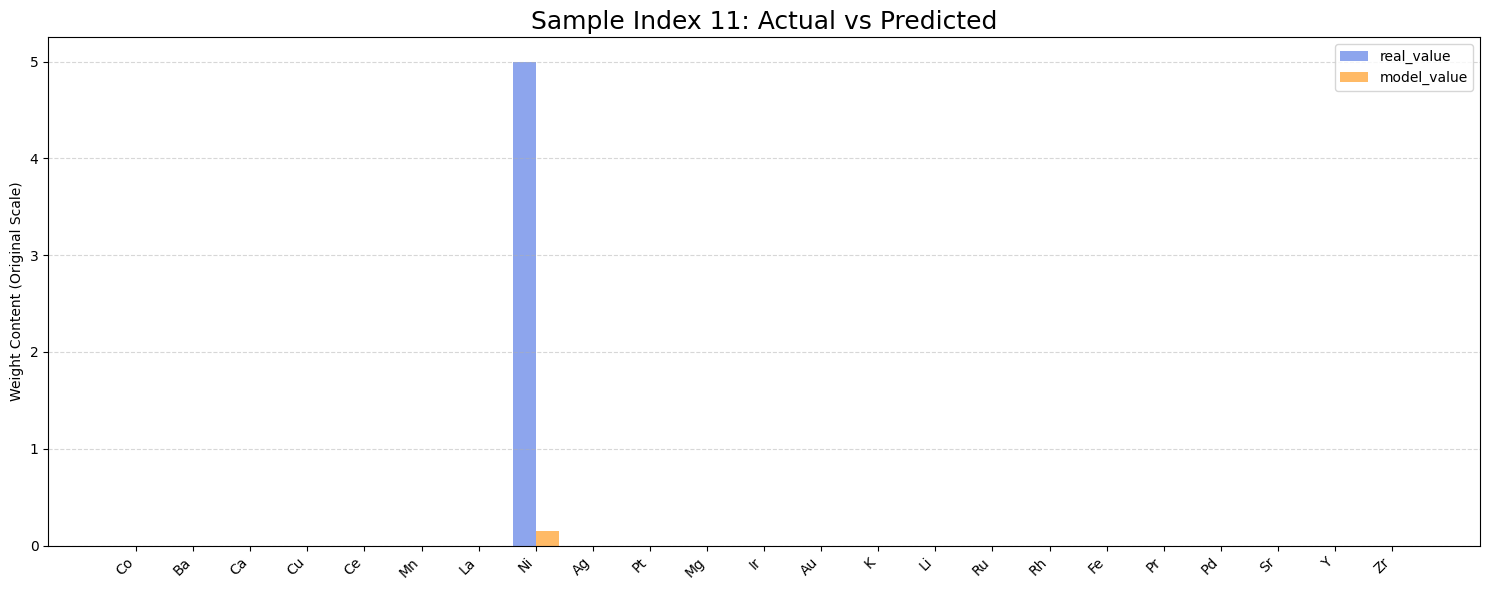

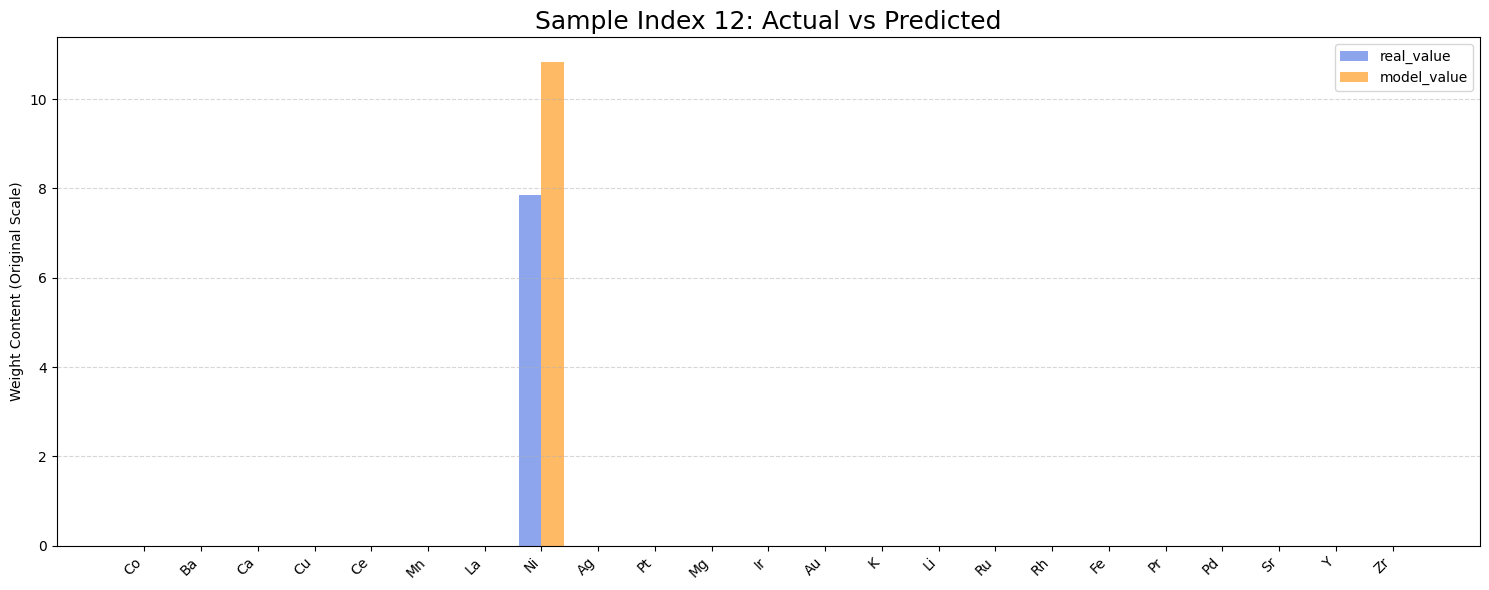

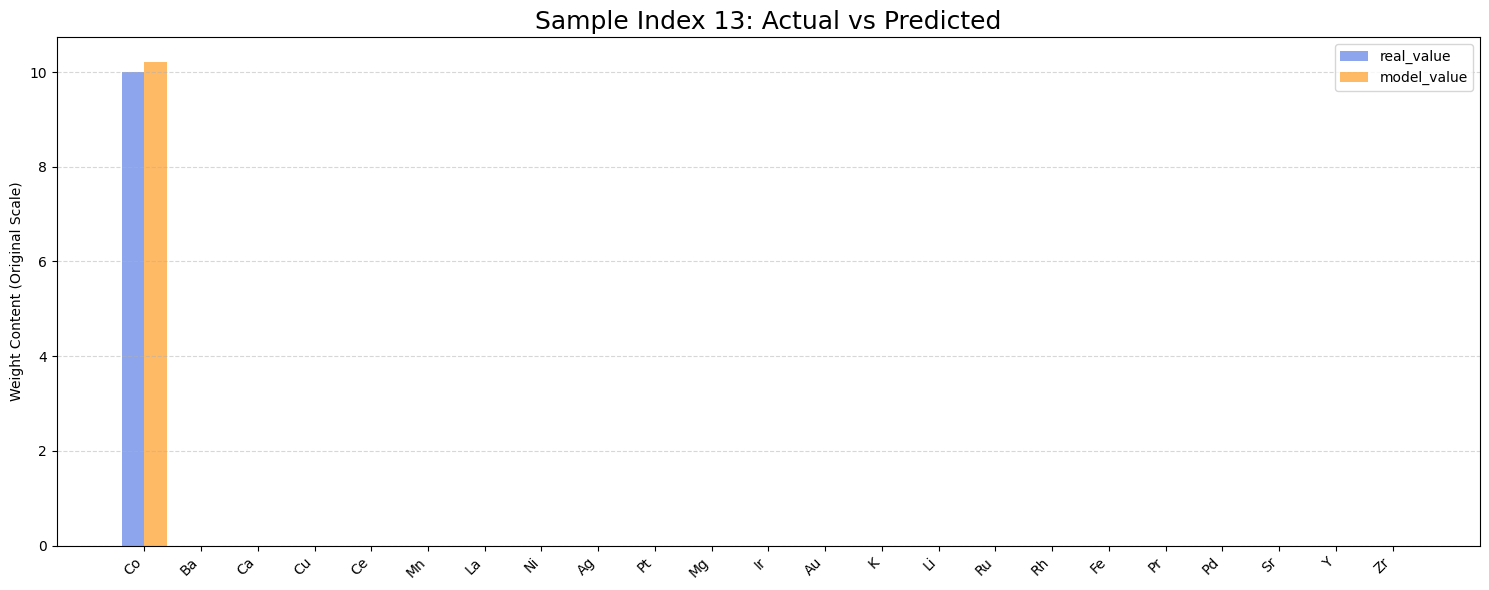

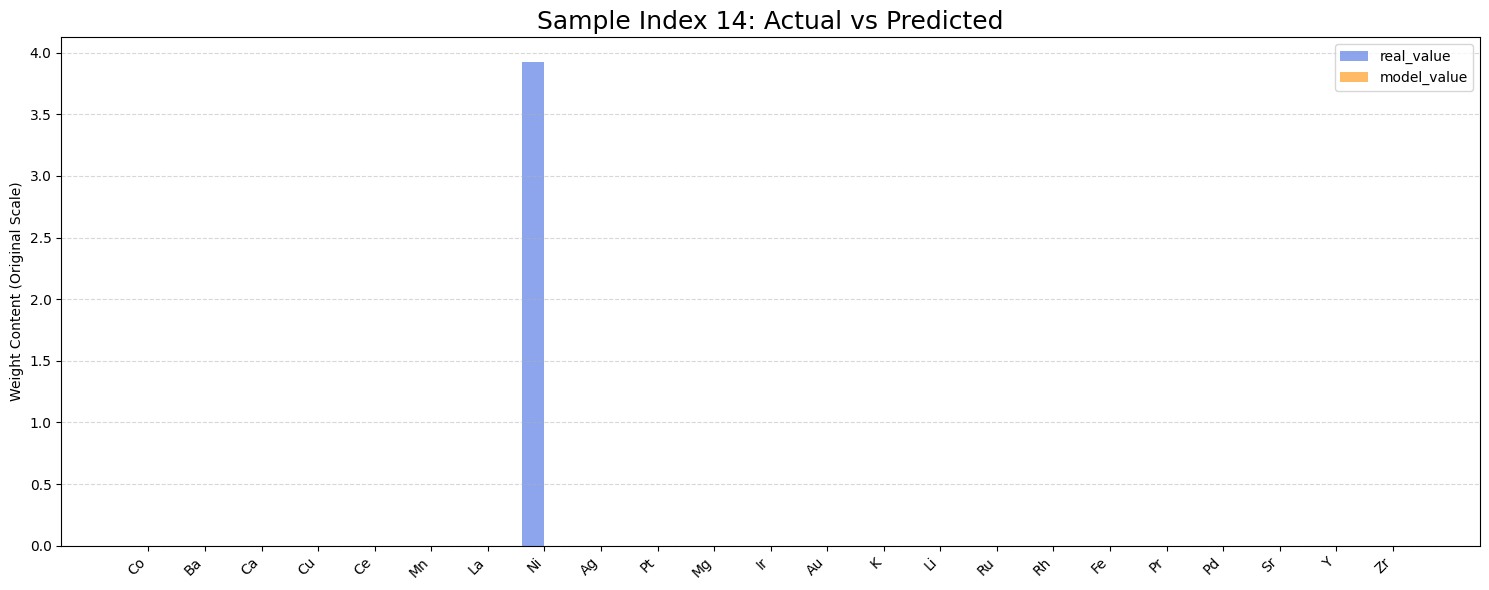


Final RMSE: 8.5716
Final R2: -23.9096


In [8]:
import numpy as np
import torch
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) 스케일러 및 컬럼명 로드
x_scaler = joblib.load('./torch/x_scaler.pkl')
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.iloc[:, 2:25].columns

# 2) 모델 추론 및 2차원 데이터 수집
model.eval()
x_true_raw_list = []
x_hat_raw_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 출력 (StandardScaler가 적용된 도메인의 예측값)
        p_logits, mu_log, logvar_log, _, _ = model(x_t, c_t)
        prob = torch.sigmoid(p_logits).cpu().numpy()
        
        # [핵심] StandardScaler 도메인에서의 기댓값 복원
        # Hurdle 모델은 내부적으로 로그 도메인(mu)을 다루므로 exp를 통해 스케일링된 함량을 구함
        clamped_var = torch.exp(torch.clamp(logvar_log, min=-7, max=2))
        pred_scaled = torch.exp(mu_log + 0.5 * clamped_var)
        
        # 3) --- 역변환 (StandardScaler Inverse Only) ---
        # 사용자님 요청대로 expm1 없이 inverse_transform만 수행
        pred_raw = x_scaler.inverse_transform(pred_scaled.cpu().numpy())
        actual_raw = x_scaler.inverse_transform(x_t.cpu().numpy())
        
        # Soft Hurdle 적용 (확률 * 복원된 원본 함량)
        x_hat_sample = prob * pred_raw
        
        x_true_raw_list.append(actual_raw)
        x_hat_raw_list.append(x_hat_sample)

# 4) (샘플 수, 금속 수) 형태의 2차원 행렬로 통합
x_true_test = np.concatenate(x_true_raw_list, axis=0)
x_hat_test = np.concatenate(x_hat_raw_list, axis=0)

# 5) 샘플별 성분 비교 시각화 (인덱스 5번 ~ 14번)
for i in range(5, 15):
    plt.figure(figsize=(15, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.4
    
    # 실제값(Blue) vs 모델예측값(Orange)
    plt.bar(x_axis - width/2, x_true_test[i], width, label='real_value', color='royalblue', alpha=0.6)
    plt.bar(x_axis + width/2, x_hat_test[i], width, label='model_value', color='darkorange', alpha=0.6)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i}: Actual vs Predicted', fontsize=18)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 6) 전체 지표 산출
y_true = x_true_test.flatten()
y_pred = x_hat_test.flatten()
print(f"\nFinal RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"Final R2: {r2_score(y_true, y_pred):.4f}")

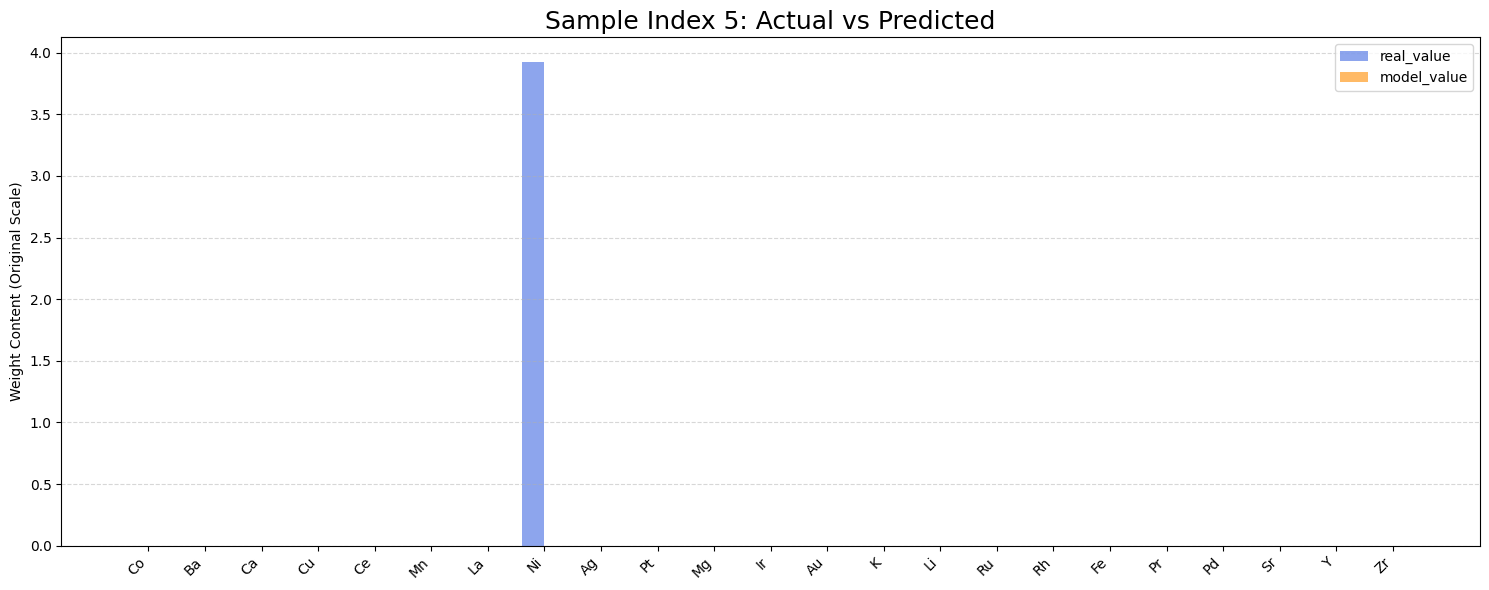

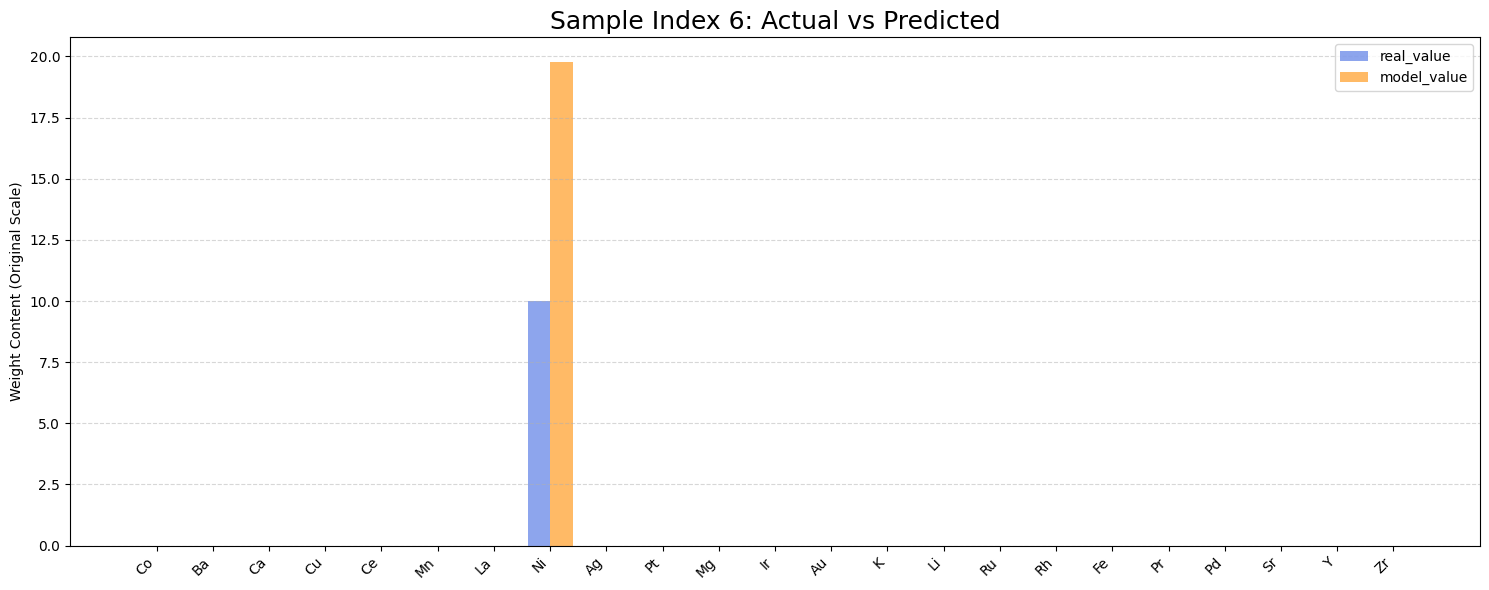

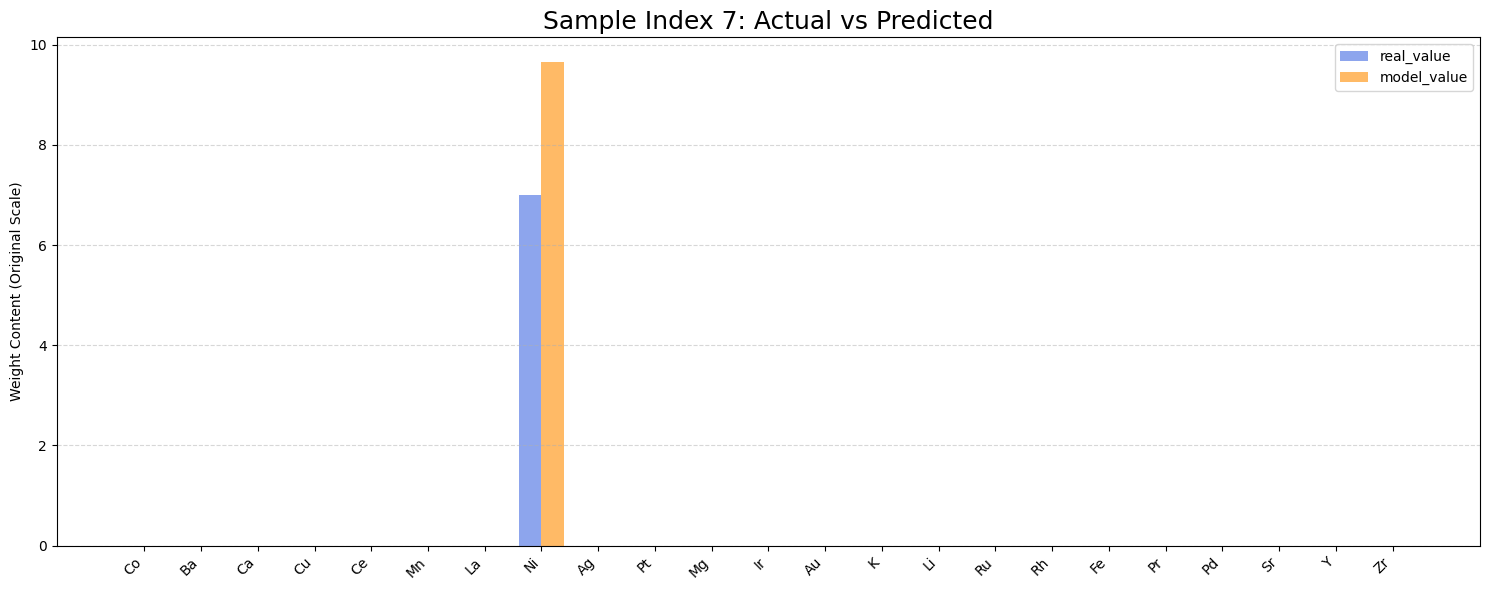

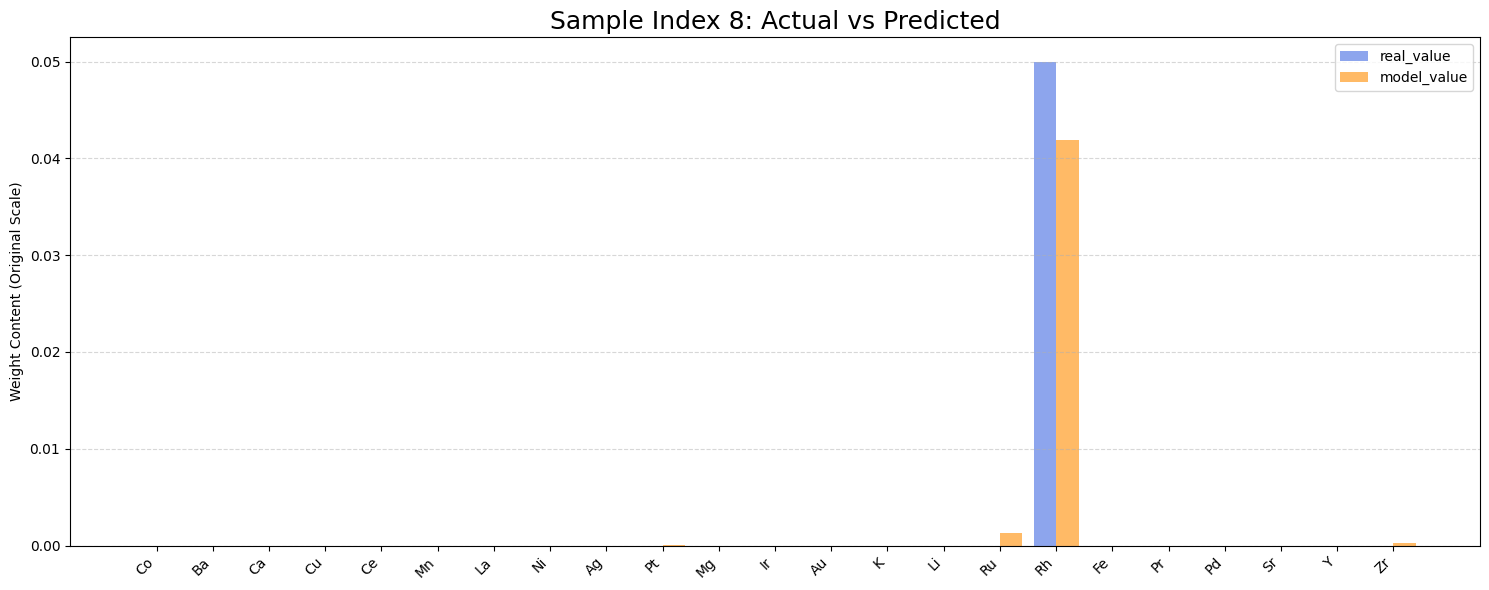

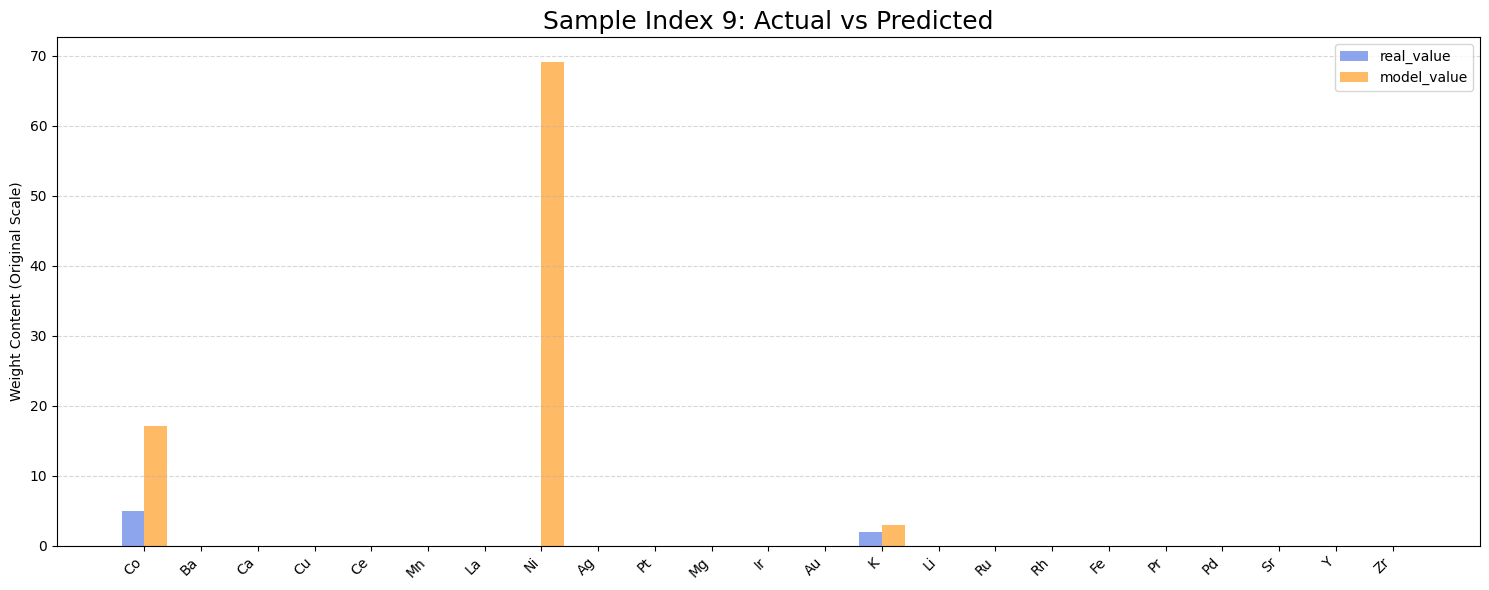

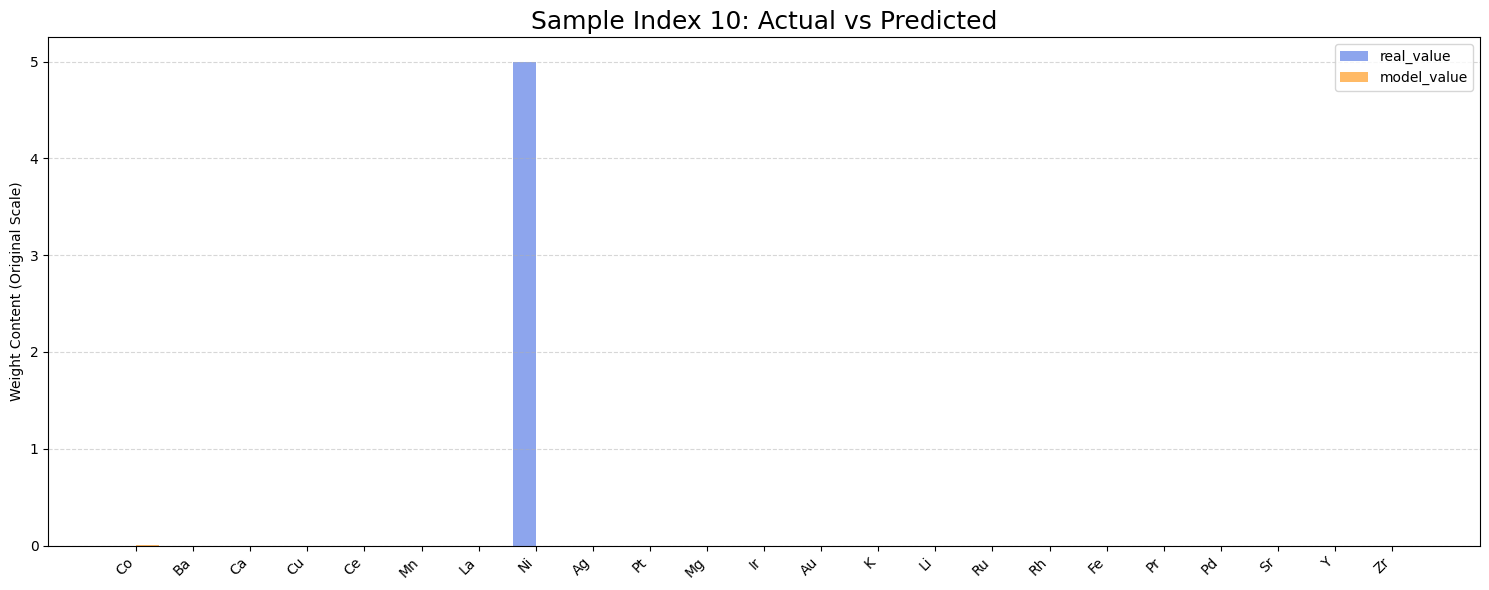

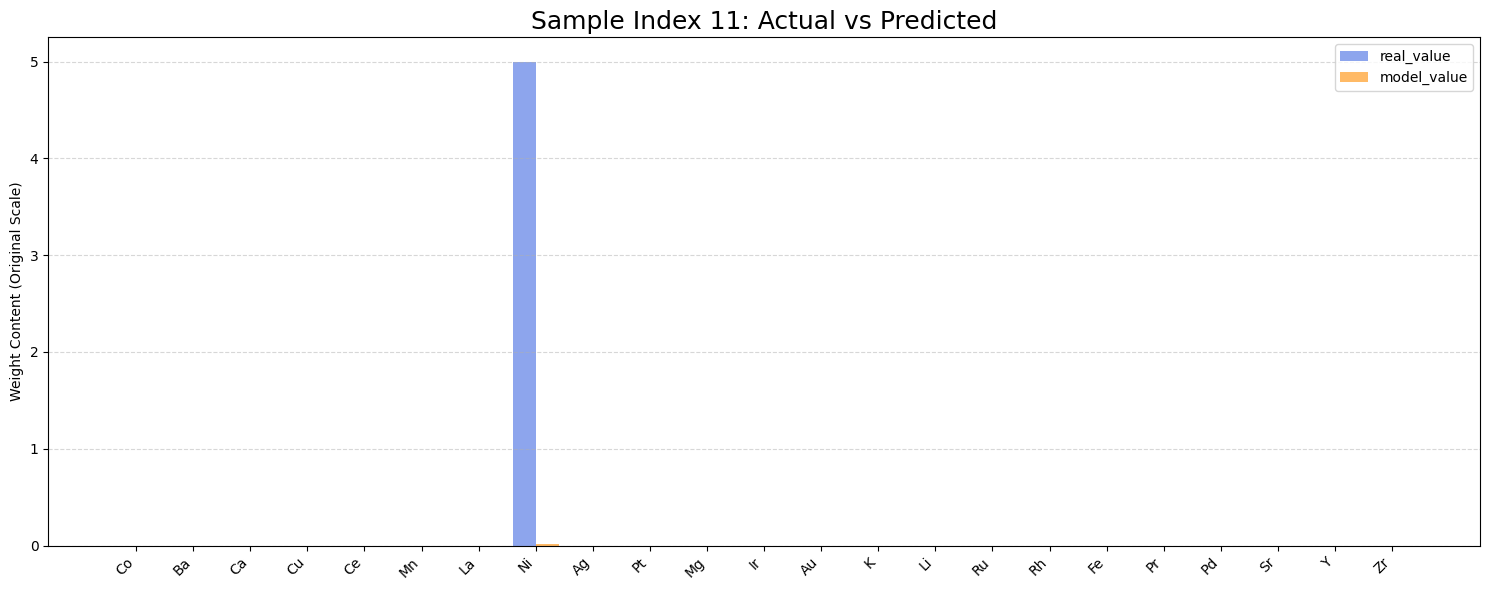

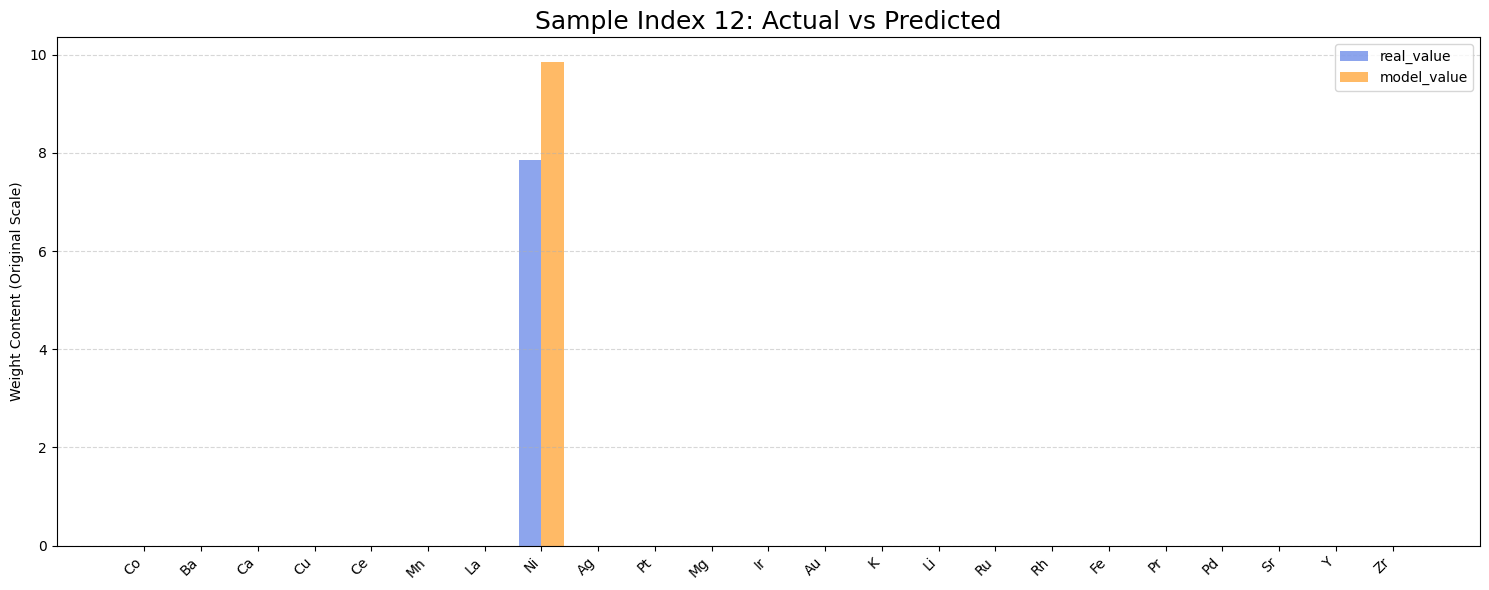

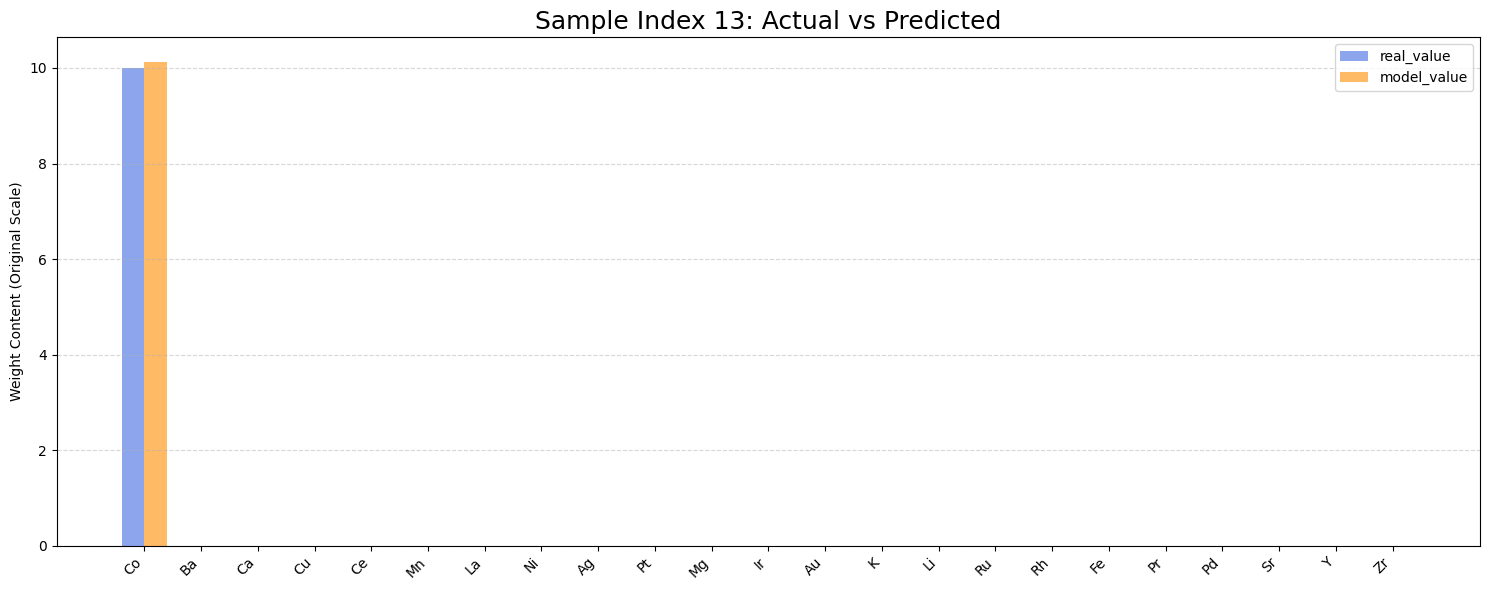

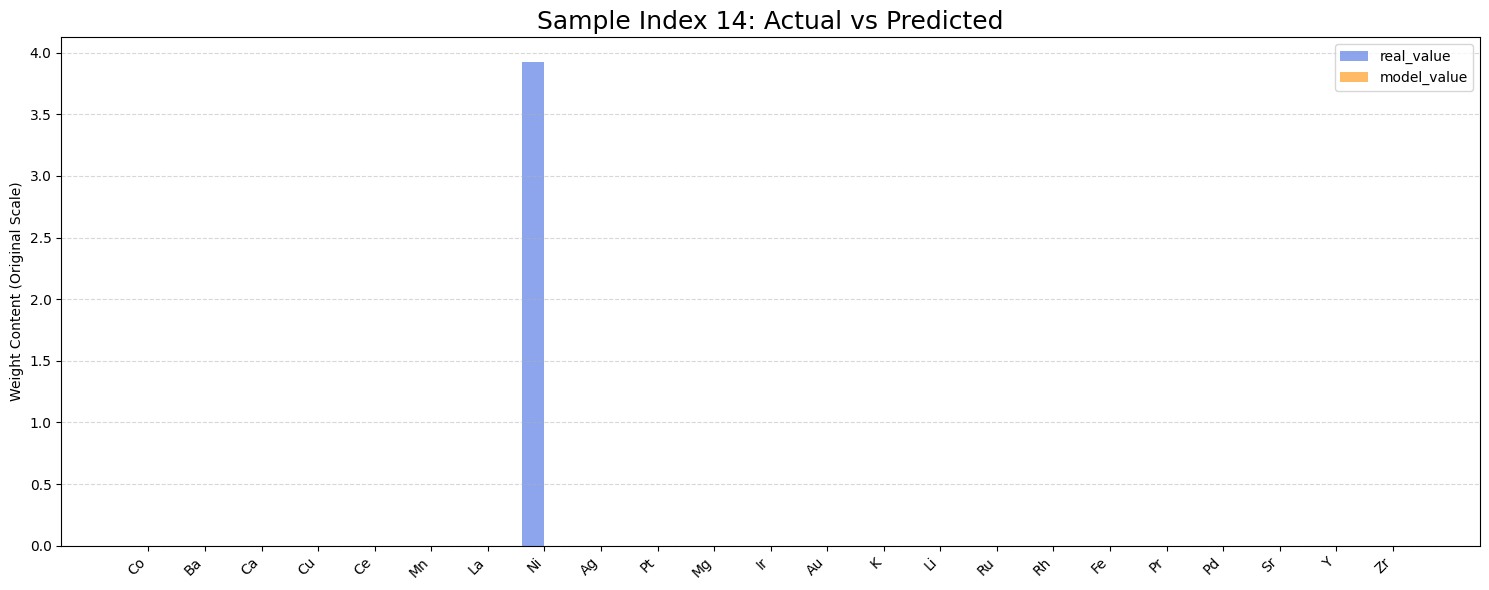


Final RMSE: 8.5354
Final R2: -23.6996


In [4]:
import numpy as np
import torch
import joblib
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# 1) 스케일러 및 컬럼명 로드
x_scaler = joblib.load('./torch/x_scaler.pkl')
df_meta = pd.read_csv('211210-DRM-total.csv')
metal_columns = df_meta.iloc[:, 2:25].columns

# 2) 모델 추론 및 2차원 데이터 수집
model.eval()
x_true_raw_list = []
x_hat_raw_list = []

with torch.no_grad():
    for x_t, c_t in test_loader:
        x_t, c_t = x_t.to(device), c_t.to(device)
        
        # 모델 출력 (StandardScaler가 적용된 도메인의 예측값)
        p_logits, mu_log, logvar_log, _, _ = model(x_t, c_t)
        prob = torch.sigmoid(p_logits).cpu().numpy()
        
        # [핵심] StandardScaler 도메인에서의 기댓값 복원
        # Hurdle 모델은 내부적으로 로그 도메인(mu)을 다루므로 exp를 통해 스케일링된 함량을 구함
        clamped_var = torch.exp(torch.clamp(logvar_log, min=-7, max=2))
        pred_scaled = torch.exp(mu_log + 0.5 * clamped_var)
        
        # 3) --- 역변환 (StandardScaler Inverse Only) ---
        # 사용자님 요청대로 expm1 없이 inverse_transform만 수행
        pred_raw = x_scaler.inverse_transform(pred_scaled.cpu().numpy())
        actual_raw = x_scaler.inverse_transform(x_t.cpu().numpy())
        
        # Soft Hurdle 적용 (확률 * 복원된 원본 함량)
        x_hat_sample = prob * pred_raw
        
        x_true_raw_list.append(actual_raw)
        x_hat_raw_list.append(x_hat_sample)

# 4) (샘플 수, 금속 수) 형태의 2차원 행렬로 통합
x_true_test = np.concatenate(x_true_raw_list, axis=0)
x_hat_test = np.concatenate(x_hat_raw_list, axis=0)

# 5) 샘플별 성분 비교 시각화 (인덱스 5번 ~ 14번)
for i in range(5, 15):
    plt.figure(figsize=(15, 6))
    x_axis = np.arange(len(metal_columns))
    width = 0.4
    
    # 실제값(Blue) vs 모델예측값(Orange)
    plt.bar(x_axis - width/2, x_true_test[i], width, label='real_value', color='royalblue', alpha=0.6)
    plt.bar(x_axis + width/2, x_hat_test[i], width, label='model_value', color='darkorange', alpha=0.6)
    
    plt.xticks(x_axis, metal_columns, rotation=45, ha='right')
    plt.title(f'Sample Index {i}: Actual vs Predicted', fontsize=18)
    plt.ylabel('Weight Content (Original Scale)')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

# 6) 전체 지표 산출
y_true = x_true_test.flatten()
y_pred = x_hat_test.flatten()
print(f"\nFinal RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
print(f"Final R2: {r2_score(y_true, y_pred):.4f}")